# Purpose

The purpose of this notebook is to compare the RMSE score from two different hyperparameter tuning methods; RandomizedSearchCV and BayesSearchCV.<br>
The Summary section shows a summary of the results.<br>

 * BayesSearchCV is an intelligent hyperparameter tuning search that can identify regions of a search space that will return hyperparameters that produce better scores.
 * RandomizedSearchCV is a non-intelligent (it does not learn from prior hyperparams tested) hyperparameter tuning search that tries random hyperparameters based on the distributions given.
 
In the Summary section the following observations were noted:
 * RandomizedSearchCV is faster in all cases due to parallel computing.  BayesSearchCV is mostly sequential processing due to the nature of the algorithmn.
 * RandomizedSearchCV performs poorly with lower iterations whereas BaysSearchCV performs much better.
 * RandomizedSearchCV after a certain number of iterations does not seem to produce much imporvements whereas BayesSearchCV improves greatly which makes sense given its nature of optimizations.
 * After a given threashold (50 iterstions), RandomizedSearchCV produced the better scores up until 200 iterations where BayesSearchCV produced better scores (not by much, however). 

Surprisingly, RandomizedSearchCV performed rather well for being an non-intelligent search method.  In most cases RandomizedSearchCV produced the best scores while taking less time to execute its task.<br>
There is a balance with hyperparameter tuning that requires the user to consider their cost budget when it comes to time and computing resources.<br>
Based off the results form this experiment, RandomizedSearchCV produces satisfactory while producing those results with quicker execution time.<br>

Some notes:  The seed was changed for each change in the number of iterations.  There was a situation where RandomizedSearchCV was producing the best score regardless of the iteration number and this was due to chance that the best hyperparameters were randomly selected early in the iterations.  A better test would remove the seed/random_state to inject pure randomness and test each iteration level several times to create a distribution of scores for each iteration level.  However, that would be rather resource intensive.  Also, this test did not set out to conduct extensive feature engineering or feature selection.  It is quite possible that impacted the results.  However, both RandomizedSearchCV and BayesSearchCV scores were generally in the same ballpark.

# Loading Libraries
some might not be used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from scipy import stats

In [155]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from feature_engine import encoding as enc
from feature_engine import imputation as imp
from feature_engine import transformation as trans
from feature_engine.wrappers import SklearnTransformerWrapper

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from skopt.plots import plot_objective

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Loading Data and EDA

In [2]:
df1 = pd.read_csv('C:\\Users\\bjohn\\Desktop\\Data Science\\RandomDatasets\\USA_Housing.csv')

In [4]:
df1.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [96]:
pd.options.display.float_format = '{:.2f}'.format
# pandas was displaying scientific notations for the 'Price' target which made it hard to read

pd.options.display.max_columns = None

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


In [46]:
X = df1.drop(columns='Price')
y = df1['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Xy_train = pd.concat([X_train, y_train], axis=1)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3350 entries, 1522 to 860
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              3350 non-null   float64
 1   Avg. Area House Age           3350 non-null   float64
 2   Avg. Area Number of Rooms     3350 non-null   float64
 3   Avg. Area Number of Bedrooms  3350 non-null   float64
 4   Area Population               3350 non-null   float64
 5   Address                       3350 non-null   object 
dtypes: float64(5), object(1)
memory usage: 183.2+ KB


In [58]:
Xy_train.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,3350.00,3350.00,3350.00,3350.00,3350.00,3350.00
mean,68596.08,5.97,6.99,3.99,36055.73,1229792.90
std,10717.60,0.99,1.01,1.23,9969.38,356372.84
min,17796.63,2.68,3.24,2.00,3285.45,15938.66
25%,61417.75,5.31,6.30,3.15,29353.70,991932.50
50%,68949.33,5.97,7.01,4.05,36245.43,1228671.52
75%,75904.63,6.67,7.67,4.50,42803.45,1474514.39
max,104702.72,9.52,10.28,6.50,69621.71,2370231.32


In [70]:
def histo(data):
    data.hist(figsize=(10,10), )
    plt.tight_layout()

# distributions look relatively gaussian for the most part

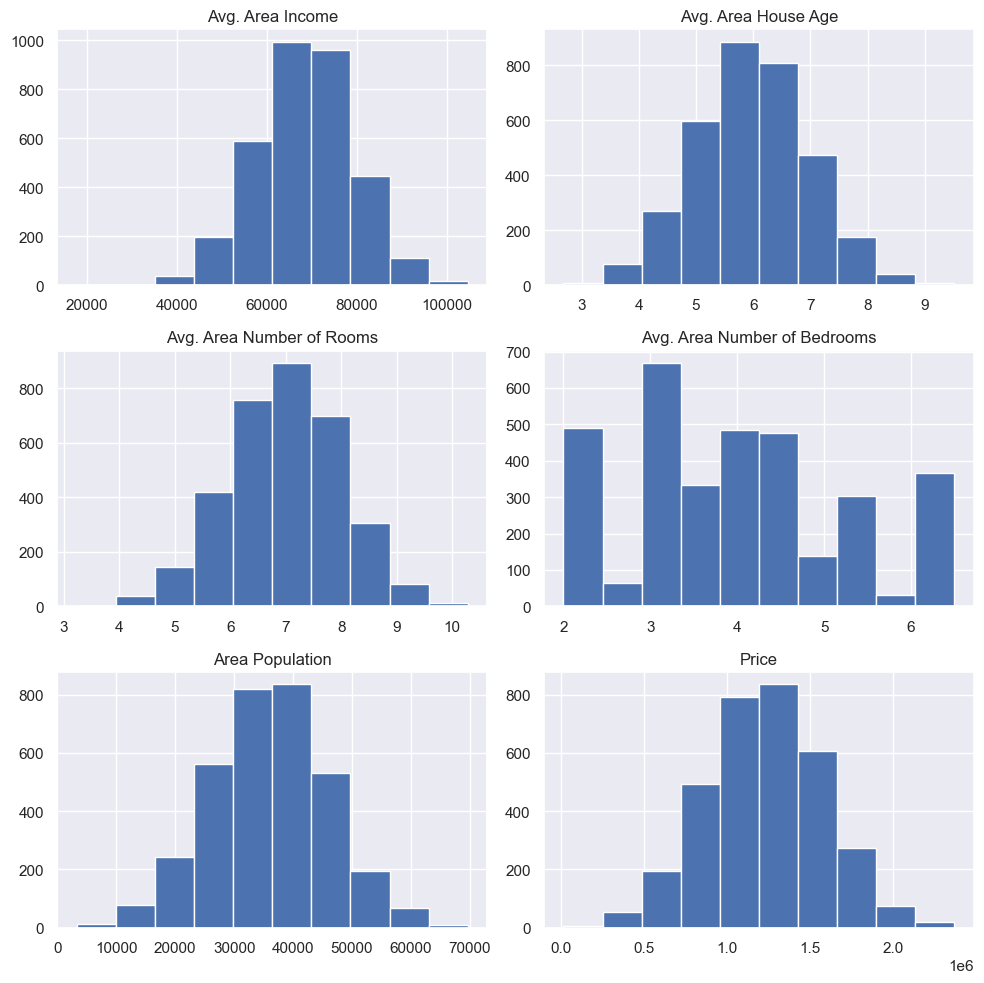

In [71]:
histo(Xy_train)

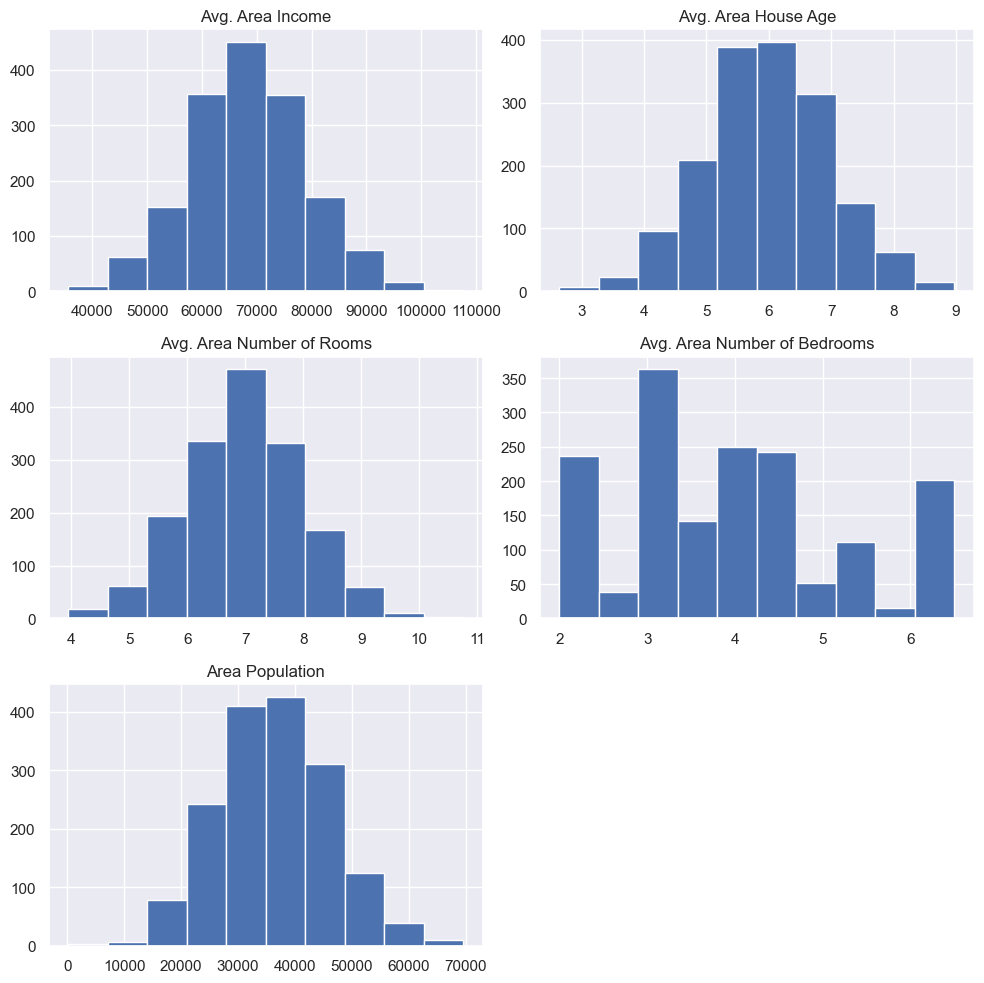

In [72]:
histo(X_test)

In [61]:
def scaled_boxplot(data):
    scaler = SklearnTransformerWrapper(MinMaxScaler())
    scaled_train = scaler.fit_transform(data)
    
    scaled_train.boxplot(figsize=(20,8))
    plt.title('Scaled Data')

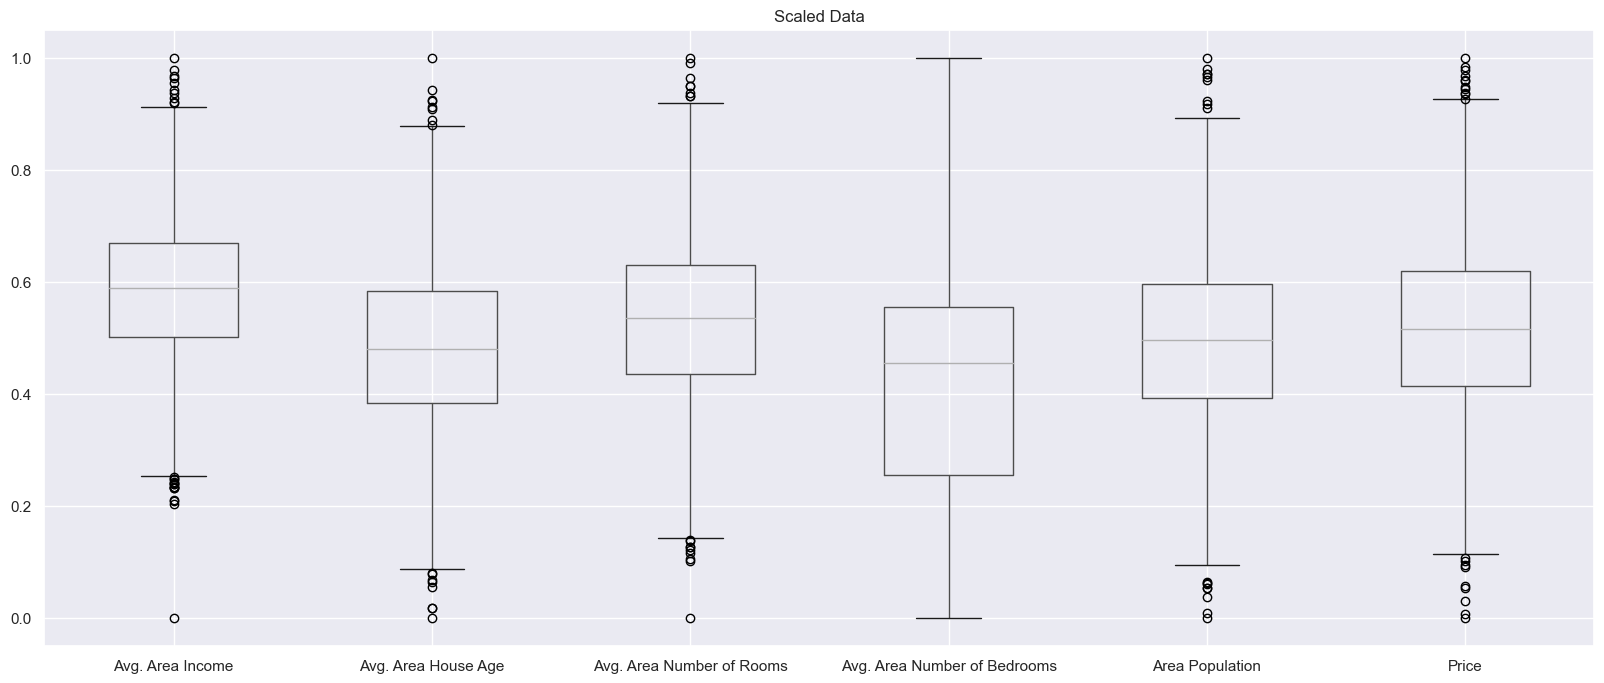

In [62]:
scaled_boxplot(Xy_train)
# scaled the data for easier multivariate analysis 
# looks like some outliers are present but, since this is a reality when it comes to features related to houses (some homes and features are expensive and cheap)
# it might not be useful to remove outliers.  

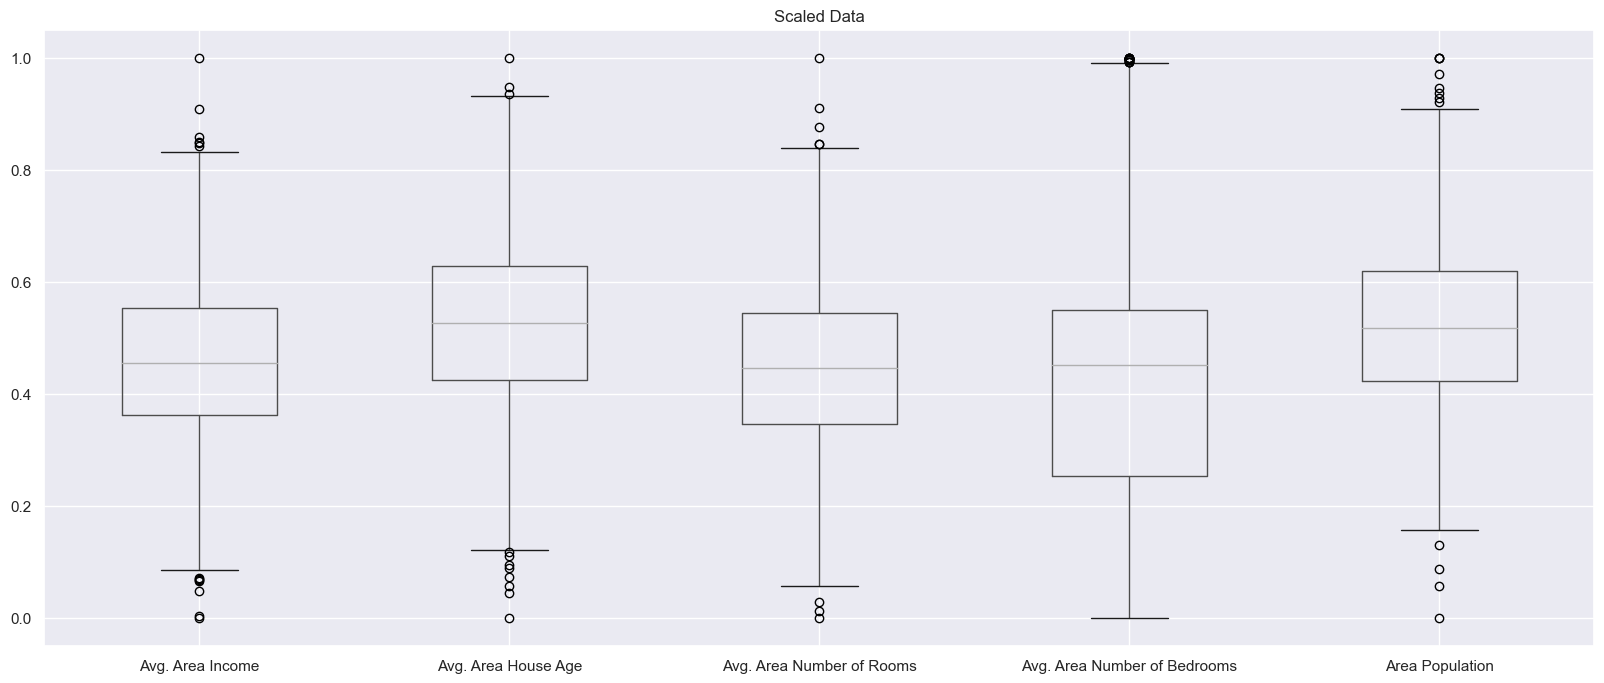

In [63]:
scaled_boxplot(X_test)

In [43]:
def corr_analysis(data):
    sns.heatmap(data.corr(), annot=True, cmap='Blues')

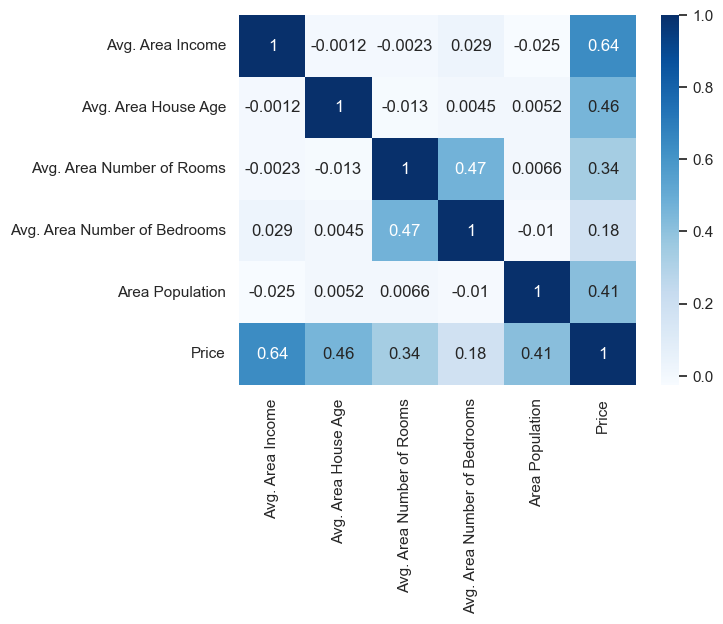

In [66]:
corr_analysis(Xy_train)

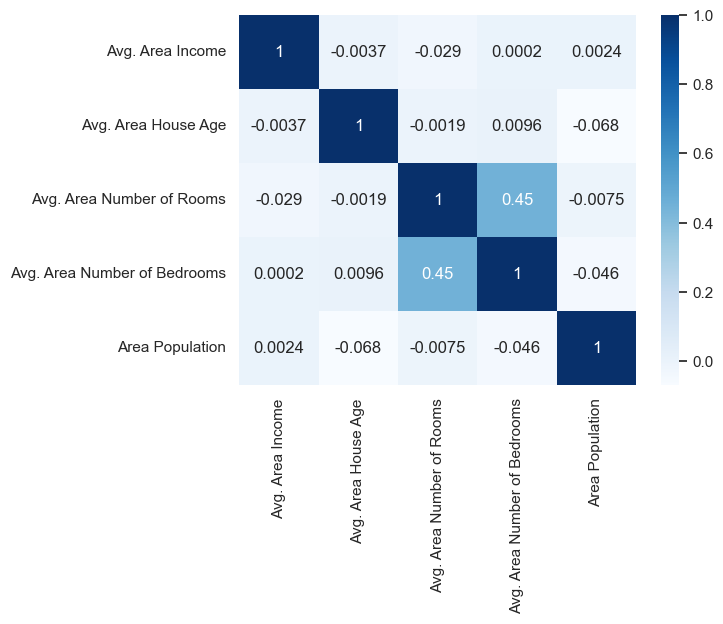

In [67]:
corr_analysis(X_test1)

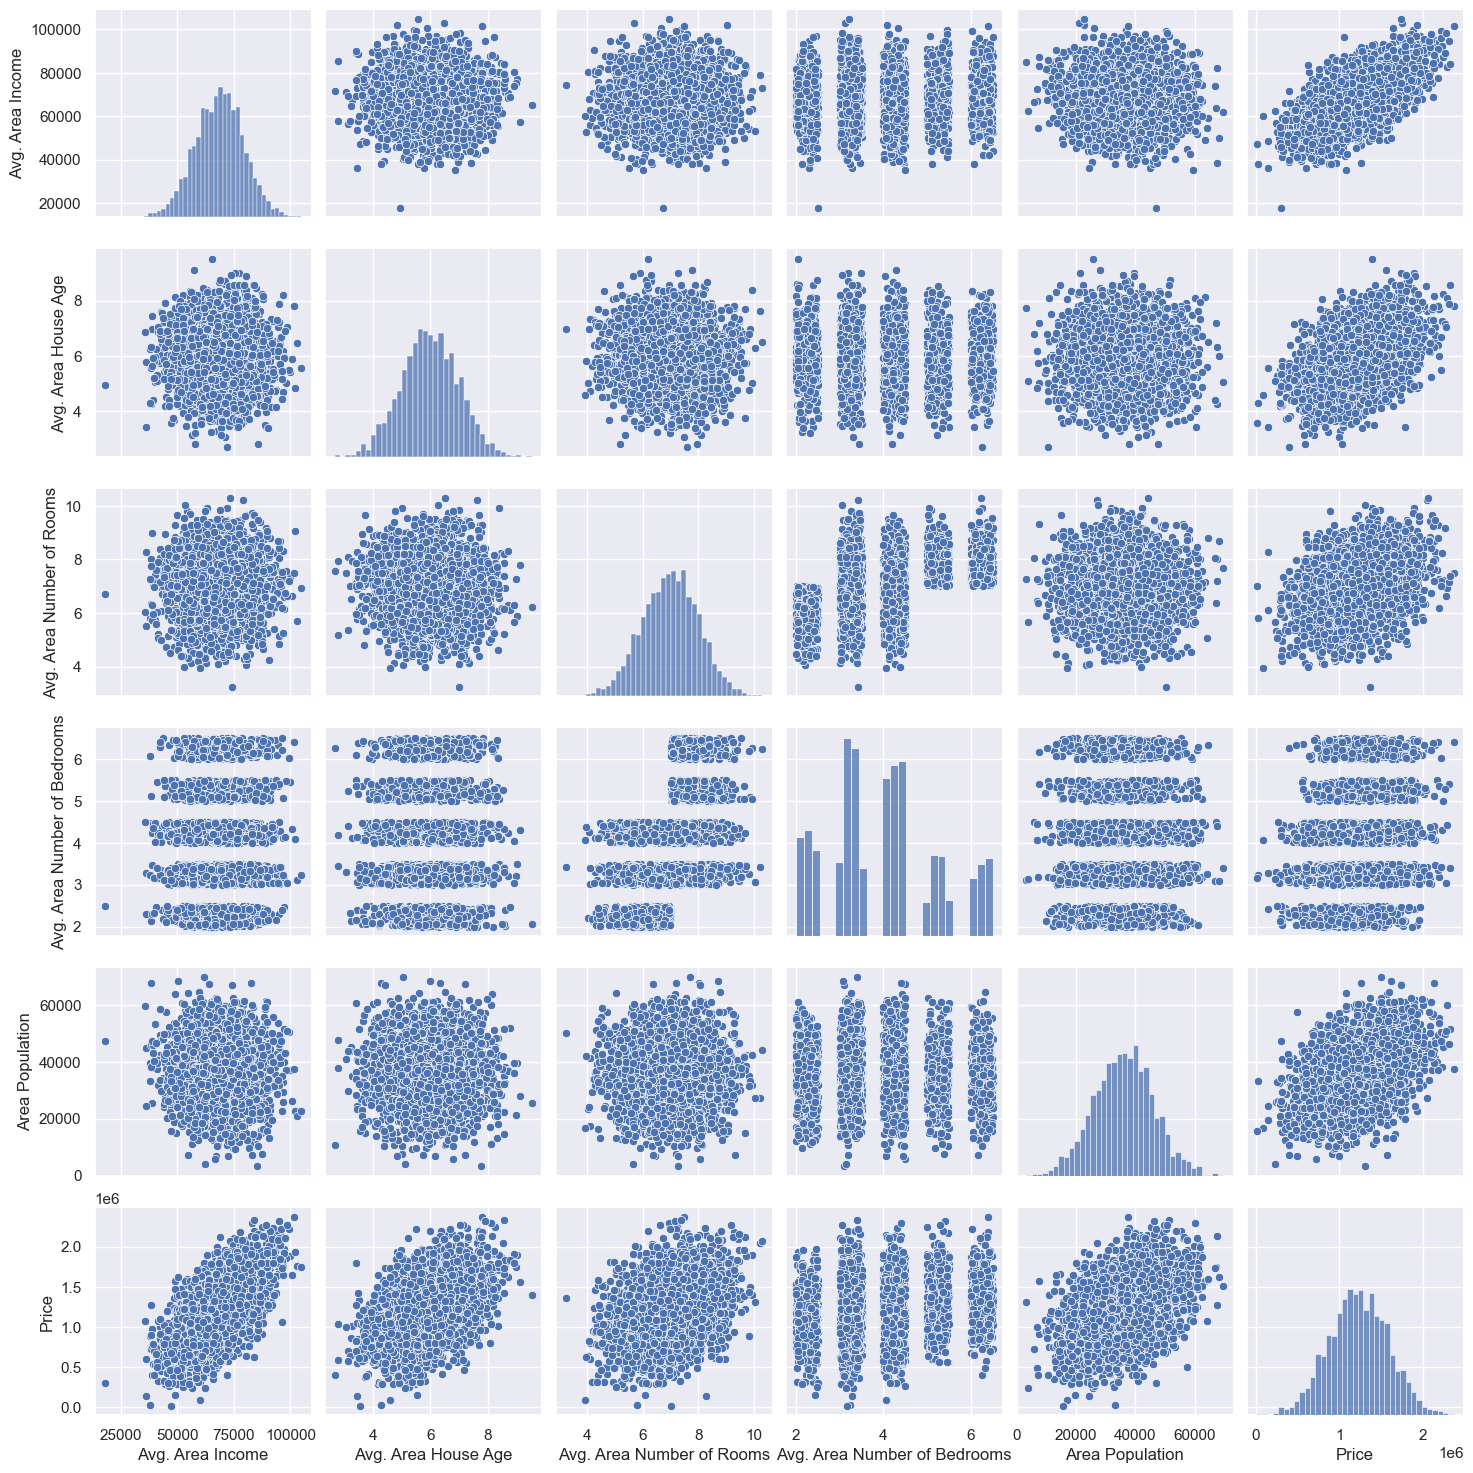

In [73]:
sns.pairplot(Xy_train)

In [68]:
def extract_numeric(X_train, X_test):
    X_train1 = X_train.select_dtypes(include= np.number)
    X_test1 = X_test.select_dtypes(include= np.number)
    return X_train1, X_test1

X_train1, X_test1 = extract_numeric(X_train, X_test)

# removing the 'Address' feature, though, extracting the state and zipcode is probably useful
# this was not a necessary function considering this feature could have been dropped when splitting the data

In [69]:
X_train1

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
1522,67716.75,6.43,7.75,5.28,40562.19
835,78095.35,6.84,7.12,3.00,32346.43
358,55577.07,6.53,7.16,3.47,19560.01
138,63876.06,7.08,7.19,3.37,38052.88
299,52188.12,5.64,5.81,4.03,42495.75
...,...,...,...,...,...
4426,76223.56,6.37,5.34,2.42,30165.34
466,56685.01,6.96,7.50,3.38,43322.17
3092,66195.34,6.51,6.61,3.14,37288.92
3772,58694.52,7.39,9.27,4.32,49960.98


# Modeling

## Tuning Function

In [114]:
def tuning(X, y, estimator, params, scoring='neg_root_mean_squared_error', iterations=100, cv=8, bayes_search=False, seed=1):
    ''' If bayes_search=False then RandomizedSearchCV is used.  If true then BayesSearchCV is used.
    Returns: Results, Fitted Model'''
    
    if bayes_search == False:
        rand_search = RandomizedSearchCV(
            estimator= estimator, 
            param_distributions= params, 
            scoring= scoring, 
            cv= cv, 
            n_iter= iterations,
            n_jobs= -1,
            random_state=seed
        )
        
        rand_search.fit(X,y)
        print('Best Params: {}'.format(rand_search.best_params_))
        print('Best Score: {}'.format(rand_search.best_score_))
        print('')
        results = pd.DataFrame(rand_search.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
        print(results[['mean_test_score','std_test_score']].head(10))
        print('')
        results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)
        plt.ylabel('Neg RMSE')
        plt.xlabel('Iterations (Descending Scoring Order)')
        
        return results, rand_search
    
    
    if bayes_search == True:
        bay_search = BayesSearchCV(estimator=estimator, 
                                   scoring=scoring, 
                                   search_spaces=params, 
                                   n_iter=iterations, 
                                   cv=cv,
                                   n_jobs=-1,
                                   random_state=seed,
                                  optimizer_kwargs = {
                                      'base_estimator':'GBRT',
                                      'n_jobs':-1,
                                      'acq_func':'EI'
                                  })
        bay_search.fit(X,y)
        print('Best Params: {}'.format(bay_search.best_params_))
        print('Best Score: {}'.format(bay_search.best_score_))
        print('')
        results = pd.DataFrame(bay_search.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
        print(results[['mean_test_score','std_test_score']].head(10))
        print('')
        results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)
        plt.ylabel('Neg RMSE')
        plt.xlabel('Iterations (Descending Scoring Order)')
        plot_objective(bay_search.optimizer_results_[0])
        
        return results, bay_search

## RandomizedSearchCV Tuning

### Trial 1 100 iterations

Best Params: {'gamma': 5.586942415474672, 'learning_rate': 0.07027943060375737, 'max_depth': 1, 'n_estimators': 1160, 'subsample': 0.9003722843377684}
Best Score: -105971.6788290283

   mean_test_score  std_test_score
0       -105971.68         3140.25
1       -106588.58         3561.65
2       -106624.93         3365.50
3       -106704.14         3353.00
4       -106938.26         3134.06
5       -107418.25         3988.12
6       -107941.17         3314.34
7       -108074.22         3707.77
8       -108384.83         3153.16
9       -108624.04         3181.29

CPU times: total: 14.1 s
Wall time: 2min 14s


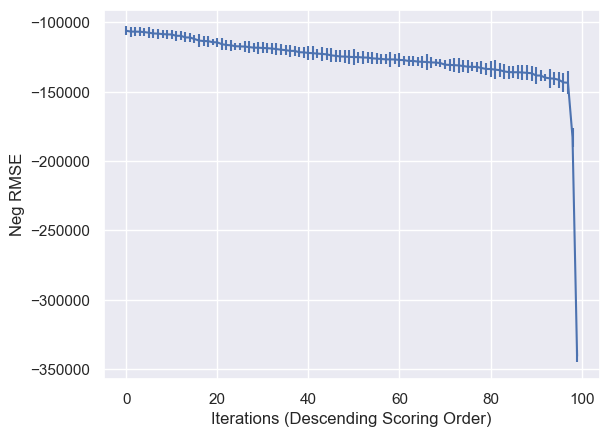

In [157]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results1, rand_model1 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params)

### Trial 2 50 iterations

Best Params: {'gamma': 4.26028265830812, 'learning_rate': 0.161504819294635, 'max_depth': 1, 'n_estimators': 474, 'subsample': 0.8556086213937213}
Best Score: -106321.98772882146

   mean_test_score  std_test_score
0       -106321.99         3478.84
1       -108555.65         3627.66
2       -108603.77         3626.34
3       -108770.64         2709.61
4       -108979.12         3476.26
5       -111857.16         2638.31
6       -111923.77         3946.61
7       -112887.70         4353.93
8       -113741.65         4944.79
9       -114733.88         4699.29

CPU times: total: 6.28 s
Wall time: 1min 18s


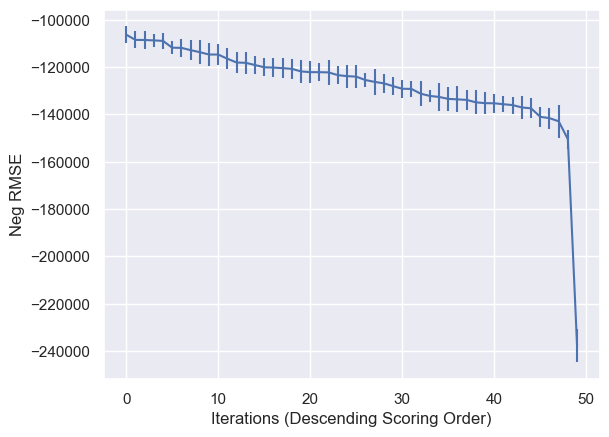

In [137]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results2, rand_model2 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, iterations=50, seed=2)

### Trial 3 25 iterations

Best Params: {'gamma': 5.727981419301764, 'learning_rate': 0.16297099831663076, 'max_depth': 1, 'n_estimators': 1083, 'subsample': 0.5307644654149697}
Best Score: -106355.901015665

   mean_test_score  std_test_score
0       -106355.90         3048.38
1       -106502.63         3142.70
2       -107738.90         3856.13
3       -109252.92         3314.64
4       -110471.98         4020.67
5       -112694.88         4723.99
6       -114031.58         4635.16
7       -115774.54         2589.21
8       -117282.75         4432.41
9       -120563.73         4404.24

CPU times: total: 11.6 s
Wall time: 37.3 s


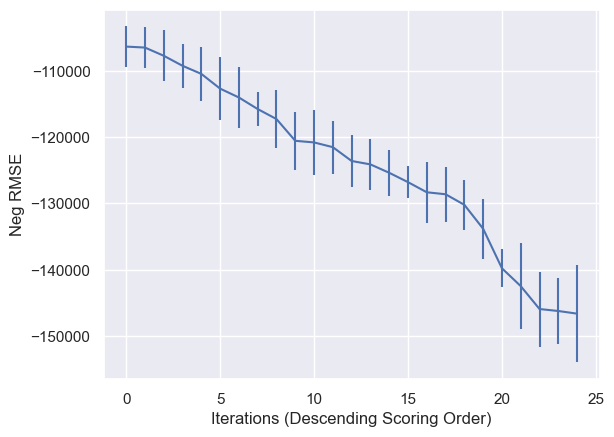

In [141]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results3, rand_model3 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, iterations=25, seed=3)

### Trial 4 10 iterations

Best Params: {'gamma': 9.670301687152865, 'learning_rate': 0.2736614013629436, 'max_depth': 2, 'n_estimators': 410, 'subsample': 0.8574079968371824}
Best Score: -113673.20960711924

   mean_test_score  std_test_score
0       -113673.21         3662.98
1       -113934.51         4060.11
2       -114191.62         3081.38
3       -119741.28         3592.38
4       -119753.98         3925.64
5       -124113.79         2446.44
6       -124130.98         3810.07
7       -132819.55         2283.34
8       -138643.76         4265.18
9       -143362.21         4750.49

CPU times: total: 5.16 s
Wall time: 16.4 s


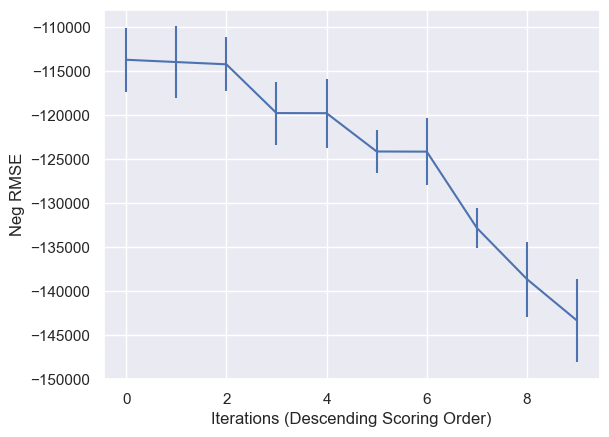

In [148]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results4, rand_model4 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, iterations=10, seed=4)

### Trial 5 200 iterations

Best Params: {'gamma': 1.330047931047421, 'learning_rate': 0.10855031073264322, 'max_depth': 1, 'n_estimators': 605, 'subsample': 0.714680505817949}
Best Score: -106134.92741317506

   mean_test_score  std_test_score
0       -106134.93         3170.53
1       -106359.22         3442.96
2       -106405.51         3138.88
3       -106561.02         3052.37
4       -106665.81         3170.12
5       -107016.82         3062.70
6       -107137.18         3465.03
7       -107274.60         2836.27
8       -107879.01         3529.66
9       -107885.01         4050.42

CPU times: total: 10.2 s
Wall time: 4min 22s


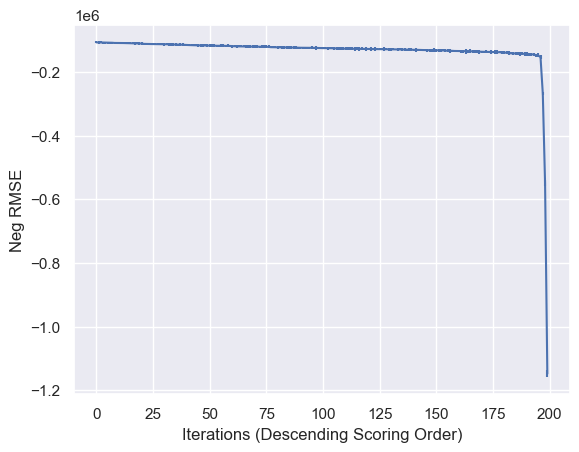

In [151]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results5, rand_model5 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, iterations=200, seed=5)

## BayesSearchCV Tuning

### Trail 1 100 iterations

Best Params: OrderedDict([('gamma', 1.728277329296908), ('learning_rate', 0.4633968951799578), ('max_depth', 1), ('n_estimators', 819), ('subsample', 0.9985947080314637)])
Best Score: -107476.75044167321

   mean_test_score  std_test_score
0       -107476.75         3909.65
1       -107707.38         2686.56
2       -107814.68         2767.50
3       -108387.75         3363.94
4       -108510.36         3458.95
5       -108554.78         3348.76
6       -108622.26         3329.55
7       -108663.95         3766.43
8       -108670.36         2923.97
9       -108921.76         3269.15

CPU times: total: 59.9 s
Wall time: 3min 11s


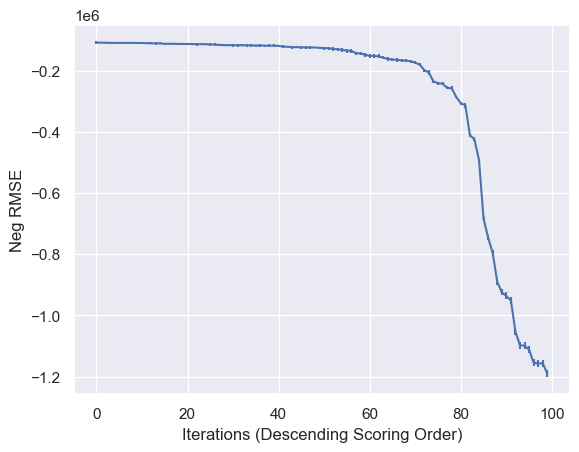

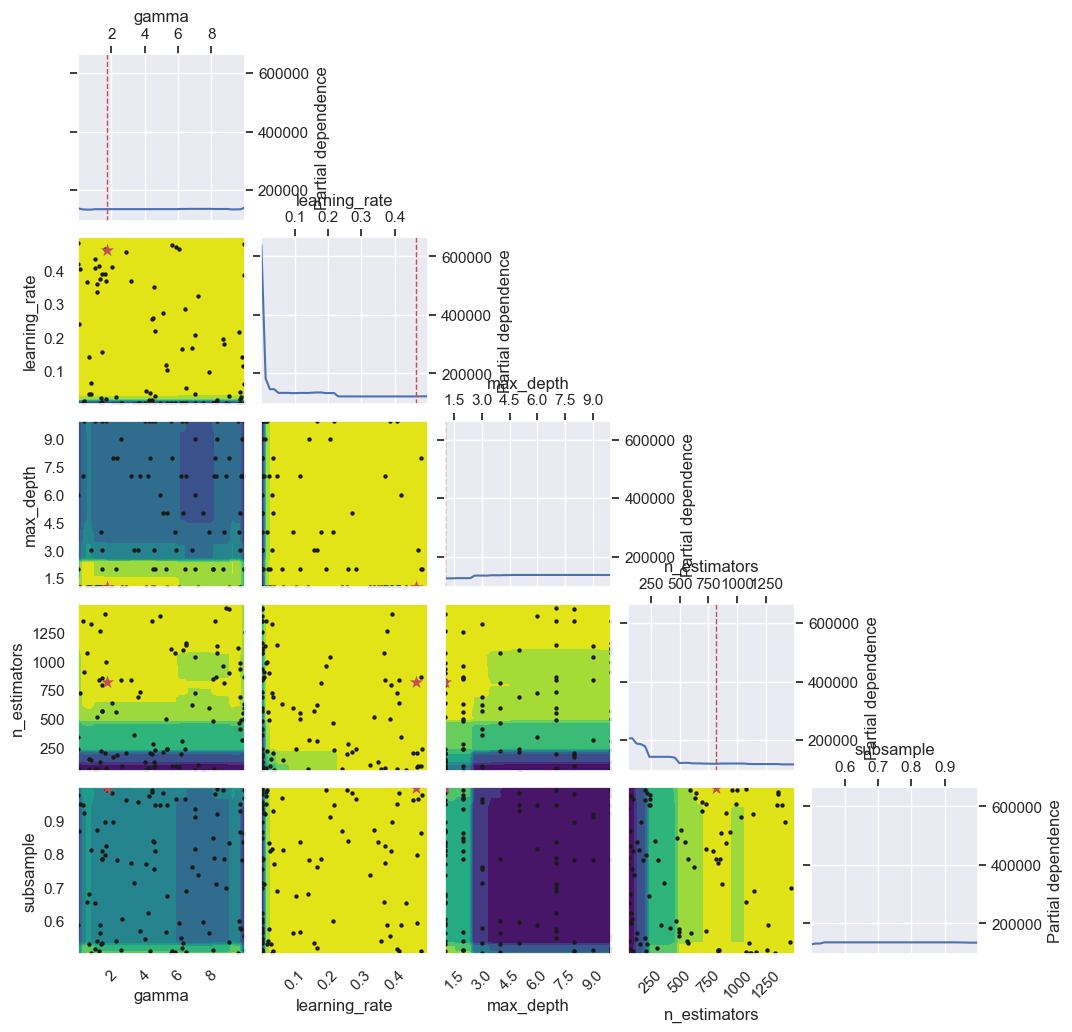

In [162]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results1, bay_model1 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True)

### Trial 2 50 iterations

Best Params: OrderedDict([('gamma', 2.104205107282835), ('learning_rate', 0.3168727626476467), ('max_depth', 1), ('n_estimators', 1092), ('subsample', 0.5750329479383182)])
Best Score: -107940.19928932539

   mean_test_score  std_test_score
0       -107940.20         3311.13
1       -108272.61         3366.36
2       -108480.19         3428.36
3       -108550.83         2844.67
4       -110530.17         3914.64
5       -111459.96         3952.30
6       -112444.19         3955.96
7       -112967.83         3898.49
8       -114282.46         5117.82
9       -115437.32         3083.13

CPU times: total: 42.9 s
Wall time: 2min 15s


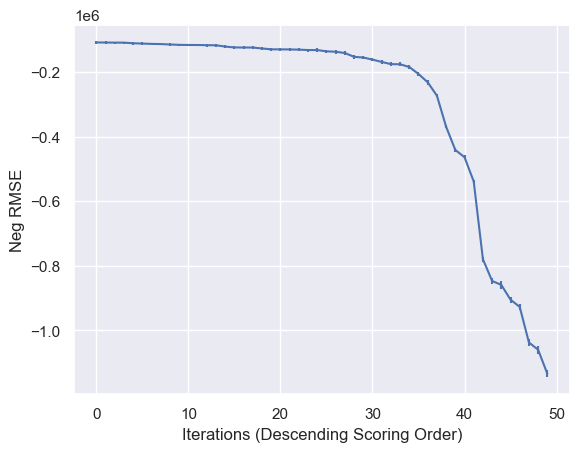

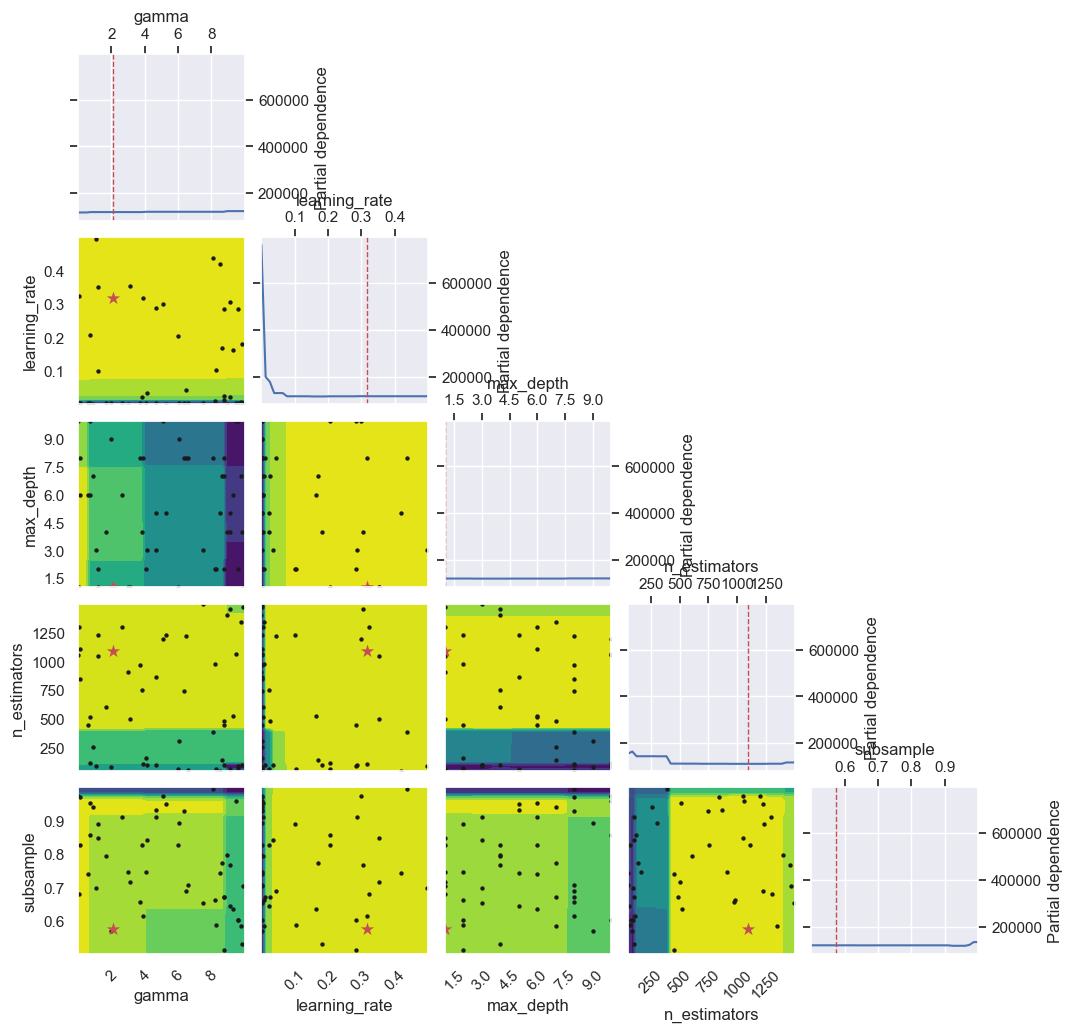

In [138]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results2, bay_model2 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True, iterations=50, seed=2)

### Trial 3 25 iterations

Best Params: OrderedDict([('gamma', 8.622288128442666), ('learning_rate', 0.024948644419236856), ('max_depth', 1), ('n_estimators', 1480), ('subsample', 0.6220771301003162)])
Best Score: -105806.80284698066

   mean_test_score  std_test_score
0       -105806.80         3316.05
1       -107361.75         3186.74
2       -107829.29         3237.37
3       -108065.32         2913.19
4       -108195.60         3690.69
5       -109499.20         3631.58
6       -109852.36         3361.04
7       -111398.26         3174.49
8       -114119.74         2792.45
9       -115656.82         3512.29

CPU times: total: 28.2 s
Wall time: 40.7 s


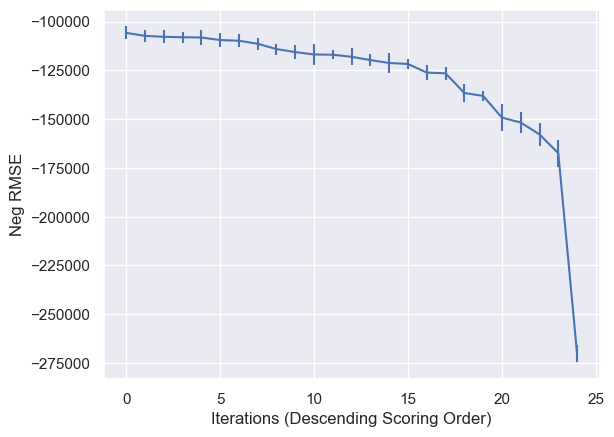

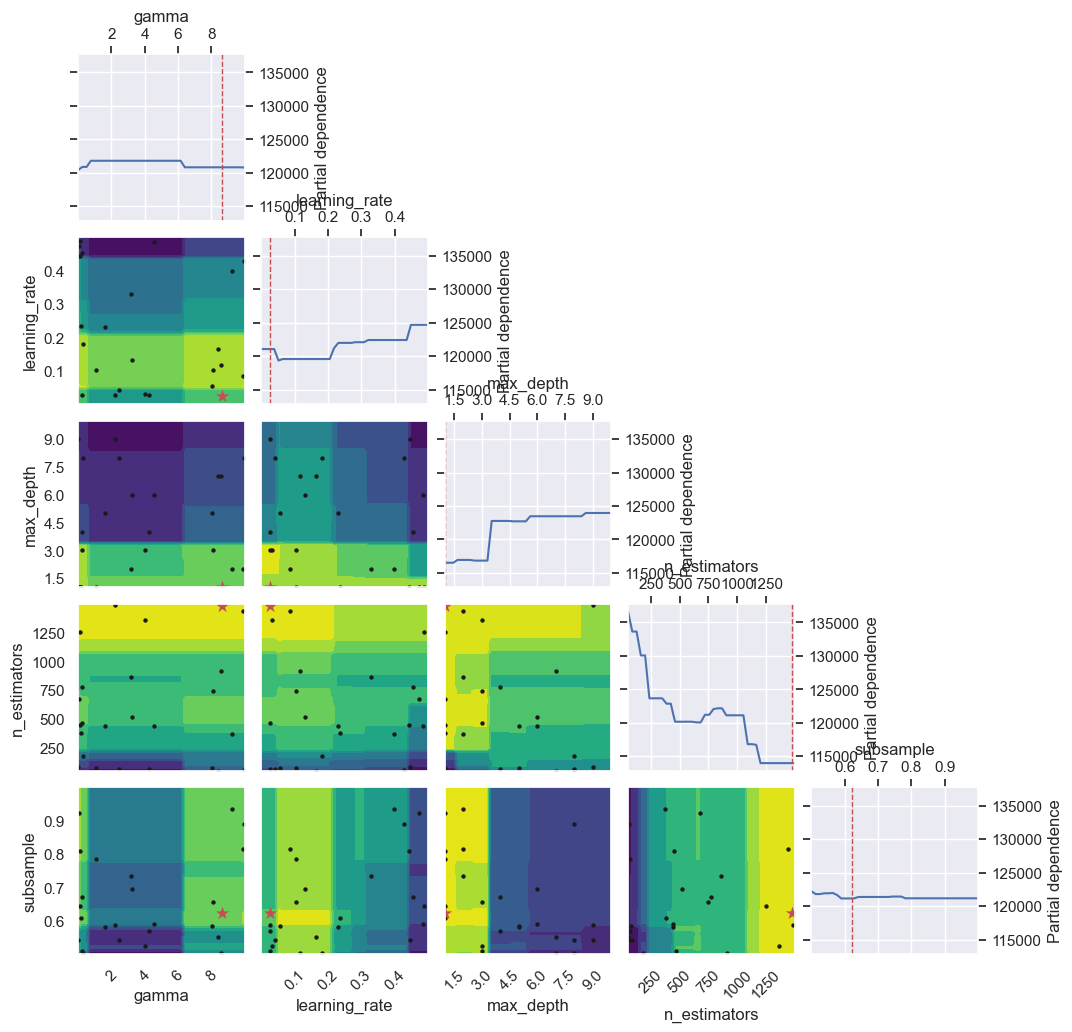

In [142]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results3, bay_model3 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True, iterations=25, seed=3)

### Trial 4 10 iterations

Best Params: OrderedDict([('gamma', 1.2683317967324015), ('learning_rate', 0.45722274221224624), ('max_depth', 1), ('n_estimators', 535), ('subsample', 0.9588428380809493)])
Best Score: -108490.97938123108

   mean_test_score  std_test_score
0       -108490.98         3370.00
1       -119595.20         4749.89
2       -120962.81         4071.99
3       -122671.46         5268.97
4       -122965.46         4462.77
5       -125628.04         3720.36
6       -130182.27         6188.46
7       -136158.83         3292.73
8       -136457.25         3956.76
9       -357703.00         4688.31

CPU times: total: 11.8 s
Wall time: 34.3 s


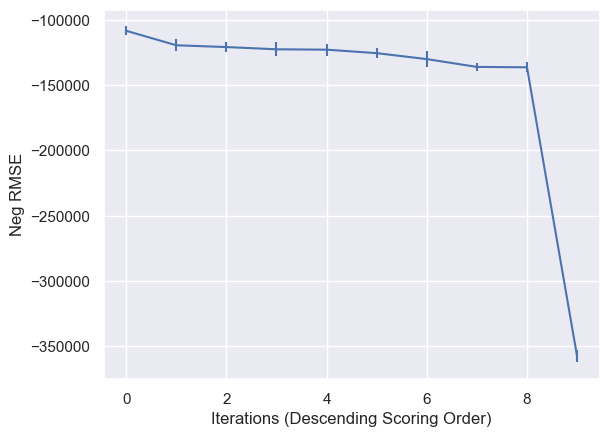

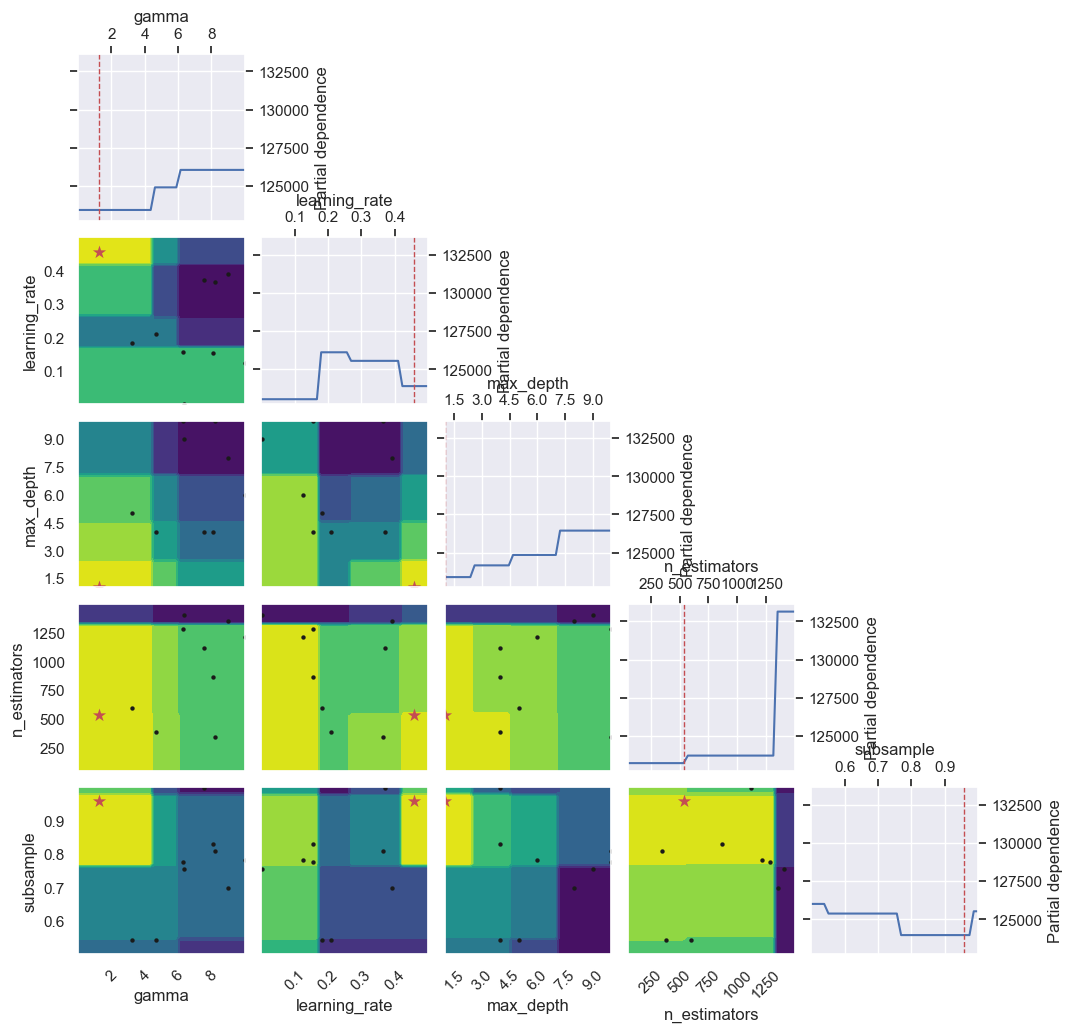

In [146]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results4, bay_model4 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True, iterations=10, seed=4)

### Trial 5 200 iterations

Best Params: OrderedDict([('gamma', 0.016547565334002715), ('learning_rate', 0.11516175136943711), ('max_depth', 1), ('n_estimators', 836), ('subsample', 0.7540834834041823)])
Best Score: -106091.61940959445

   mean_test_score  std_test_score
0       -106091.62         3420.12
1       -106116.88         3385.17
2       -106787.91         3337.46
3       -106928.45         3341.01
4       -107707.61         3555.06
5       -108031.29         3576.73
6       -108363.79         3646.25
7       -108473.76         3213.33
8       -108503.80         3268.90
9       -108592.57         2798.11

CPU times: total: 1min 56s
Wall time: 6min 59s


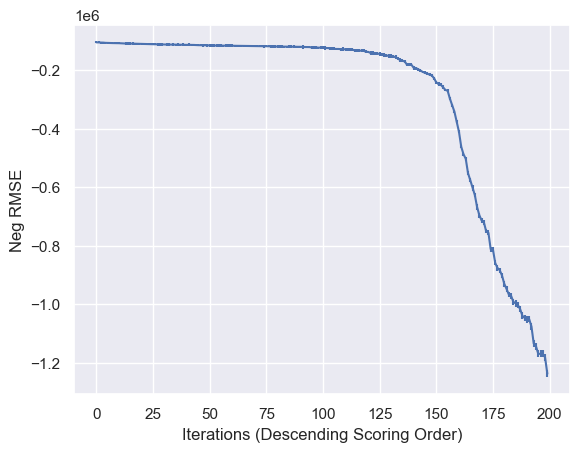

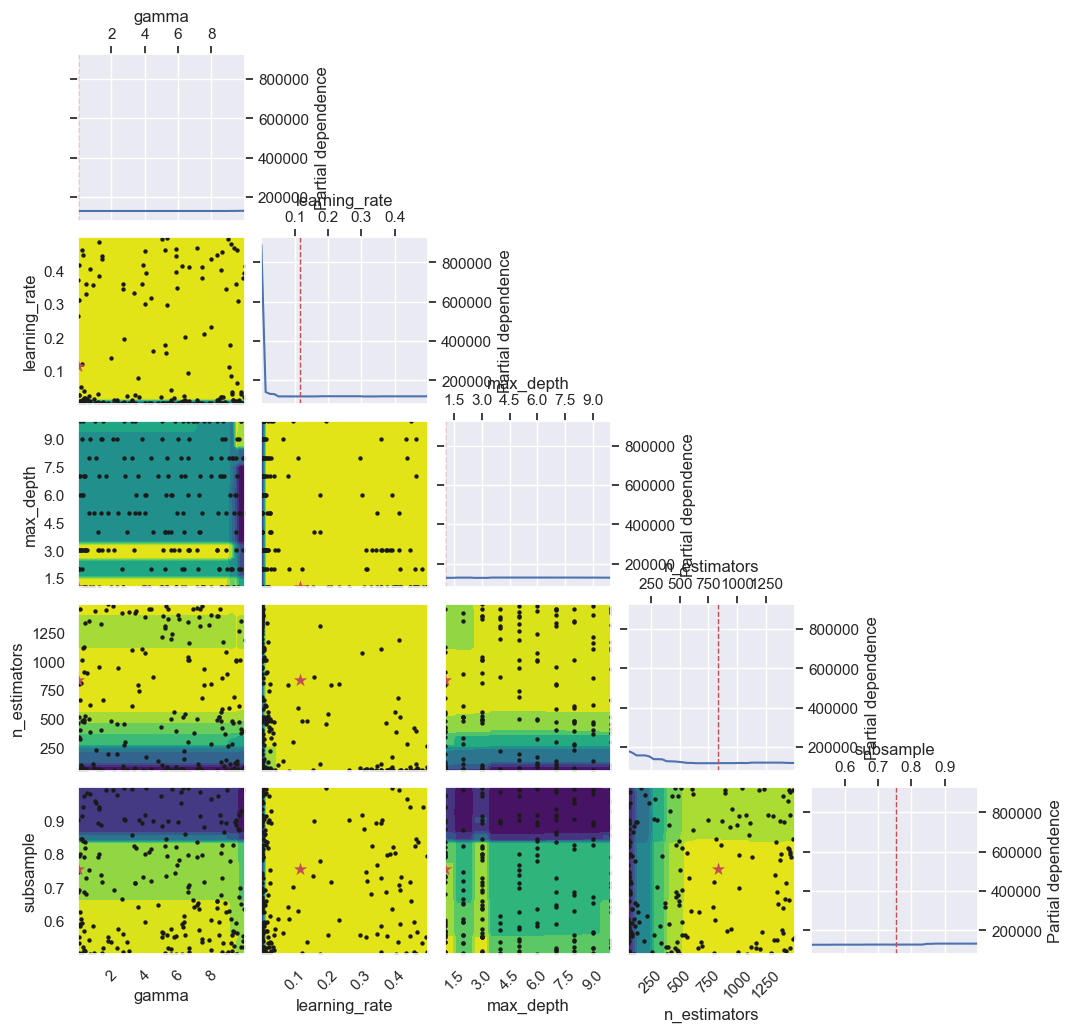

In [153]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results5, bay_model5 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True, iterations=200, seed=5)

# Compairing Results

In [124]:
xgb_cols= ['param_gamma', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_subsample', 'mean_test_score', 'std_test_score']

In [126]:
# cat_cols = ['param_depth','param_iterations','param_l2_leaf_reg','param_learning_rate','mean_test_score', 'std_test_score']

In [156]:
def scorer(estimator=None, X_test_data=None, y_test_data=None):
    y_pred = estimator.predict(X_test_data)
    score = np.sqrt(mean_squared_error(y_test_data, y_pred))
    print('RMSE : %.3f' % score)

## Trials 1 100 iterations

In [158]:
rand_results1[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,5.59,0.07,1,1160,0.90,-105971.68,3140.25
1,8.09,0.17,1,460,0.95,-106588.58,3561.65
2,8.64,0.16,1,561,0.73,-106624.93,3365.50
3,5.70,0.21,1,463,0.91,-106704.14,3353.00
4,1.35,0.25,1,1327,0.98,-106938.26,3134.06


In [160]:
scorer(rand_model1,X_test_data=X_test1, y_test_data=y_test)

RMSE : 102849.260


In [163]:
bay_results1[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,1.73,0.46,1,819,1.00,-107476.75,3909.65
1,1.43,0.39,1,792,0.81,-107707.38,2686.56
2,0.52,0.37,1,1075,0.66,-107814.68,2767.50
3,1.61,0.39,1,1415,0.90,-108387.75,3363.94
4,0.12,0.41,1,727,0.95,-108510.36,3458.95


In [164]:
scorer(bay_model1,X_test_data=X_test1, y_test_data=y_test)

RMSE : 105614.728


## Trials 2 50 iterations

In [139]:
rand_results2[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,4.26,0.16,1,474,0.86,-106321.99,3478.84
1,8.27,0.27,1,310,0.64,-108555.65,3627.66
2,7.38,0.33,1,1479,0.59,-108603.77,3626.34
3,8.16,0.07,2,917,0.55,-108770.64,2709.61
4,0.97,0.06,3,182,0.55,-108979.12,3476.26


In [165]:
scorer(rand_model2,X_test_data=X_test1, y_test_data=y_test)

RMSE : 103364.044


In [140]:
bay_results2[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,2.10,0.32,1,1092,0.58,-107940.20,3311.13
1,1.21,0.35,1,1046,0.85,-108272.61,3366.36
2,0.03,0.32,1,1301,0.68,-108480.19,3428.36
3,3.12,0.35,1,502,0.72,-108550.83,2844.67
4,3.84,0.02,4,756,0.83,-110530.17,3914.64


In [166]:
scorer(bay_model2,X_test_data=X_test1, y_test_data=y_test)

RMSE : 105255.145


## Trial 3 25 iterations

In [143]:
rand_results3[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,5.73,0.16,1,1083,0.53,-106355.90,3048.38
1,2.69,0.15,1,561,0.93,-106502.63,3142.70
2,1.57,0.27,1,1094,0.61,-107738.90,3856.13
3,2.05,0.10,2,358,0.54,-109252.92,3314.64
4,8.08,0.16,2,327,0.67,-110471.98,4020.67


In [167]:
scorer(rand_model3,X_test_data=X_test1, y_test_data=y_test)

RMSE : 104840.483


In [144]:
bay_results3[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,8.62,0.02,1,1480,0.62,-105806.80,3316.05
1,0.06,0.47,1,673,0.92,-107361.75,3186.74
2,0.19,0.24,1,380,0.61,-107829.29,3237.37
3,0.11,0.44,1,449,0.81,-108065.32,2913.19
4,0.26,0.03,3,469,0.51,-108195.60,3690.69


In [168]:
scorer(bay_model3,X_test_data=X_test1, y_test_data=y_test)

RMSE : 102735.829


## Trial 4 10 iterations

In [149]:
rand_results4[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,9.67,0.27,2,410,0.86,-113673.21,3662.98
1,1.73,0.04,4,1444,0.92,-113934.51,4060.11
2,0.09,0.19,3,224,0.98,-114191.62,3081.38
3,6.98,0.11,8,159,0.50,-119741.28,3592.38
4,0.36,0.11,8,1188,0.82,-119753.98,3925.64


In [169]:
scorer(rand_model4,X_test_data=X_test1, y_test_data=y_test)

RMSE : 110319.373


In [147]:
bay_results4[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,1.27,0.46,1,535,0.96,-108490.98,3370.00
1,8.10,0.15,4,867,0.83,-119595.20,4749.89
2,9.99,0.12,6,1214,0.78,-120962.81,4071.99
3,6.28,0.16,10,1287,0.78,-122671.46,5268.97
4,4.68,0.21,4,384,0.54,-122965.46,4462.77


In [170]:
scorer(bay_model4,X_test_data=X_test1, y_test_data=y_test)

RMSE : 105981.305


## Trial 5 200 iterations

In [152]:
rand_results5[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,1.33,0.11,1,605,0.71,-106134.93,3170.53
1,7.85,0.12,1,970,0.71,-106359.22,3442.96
2,1.01,0.19,1,828,0.98,-106405.51,3138.88
3,3.85,0.19,1,717,0.64,-106561.02,3052.37
4,3.18,0.19,1,701,0.88,-106665.81,3170.12


In [171]:
scorer(rand_model5,X_test_data=X_test1, y_test_data=y_test)

RMSE : 103529.279


In [154]:
bay_results5[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,0.02,0.12,1,836,0.75,-106091.62,3420.12
1,1.97,0.14,1,478,0.54,-106116.88,3385.17
2,7.53,0.21,1,798,0.72,-106787.91,3337.46
3,6.40,0.20,1,545,0.56,-106928.45,3341.01
4,7.98,0.23,1,804,0.60,-107707.61,3555.06


In [172]:
scorer(bay_model5,X_test_data=X_test1, y_test_data=y_test)

RMSE : 103274.121


# Summary

In [176]:
d = {
    'trial':[1,1,2,2,3,3,4,4,5,5],
    'search_method':['rand','bay','rand','bay','rand','bay','rand','bay','rand','bay'],
    'iterations':[100,100,50,50,25,25,10,10,200,200],
    'time_sec':[134,191,78,135,37,40,16,34,262,419],
    'test_score_RMSE':[102849.260,105614.728,103364.044,105255.145,104840.483,102735.829,110319.373,105981.305,103529.279,103274.121]
}

In [194]:
trial_results = pd.DataFrame(d)
trial_results.sort_values(by=['iterations', 'search_method'])

,trial,search_method,iterations,time_sec,test_score_RMSE
7,4,bay,10,34,105981.30
6,4,rand,10,16,110319.37
5,3,bay,25,40,102735.83
4,3,rand,25,37,104840.48
3,2,bay,50,135,105255.15
2,2,rand,50,78,103364.04
1,1,bay,100,191,105614.73
0,1,rand,100,134,102849.26
9,5,bay,200,419,103274.12
8,5,rand,200,262,103529.28


In [197]:
trial_results.groupby('search_method').agg(['min','max','mean','std'])[['time_sec','test_score_RMSE']]

time_sec                    test_score_RMSE                      \
                   min  max   mean    std             min       max      mean   
search_method                                                                   
bay                 34  419 163.80 157.22       102735.83 105981.30 104572.23   
rand                16  262 105.40  98.44       102849.26 110319.37 104980.49   

                       
                  std  
search_method          
bay           1465.96  
rand          3073.45

In [198]:
trial_results.query('iterations > 10').groupby('search_method').agg(['min','max','mean','std'])[['time_sec','test_score_RMSE']]
# iterations = 10 produced high error for RandomizedSearchCV.  This shows only iterations > 10.

time_sec                    test_score_RMSE                      \
                   min  max   mean    std             min       max      mean   
search_method                                                                   
bay                 40  419 196.25 161.05       102735.83 105614.73 104219.96   
rand                37  262 127.75  97.93       102849.26 104840.48 103645.77   

                       
                  std  
search_method          
bay           1427.61  
rand           847.49

Text(0.5, 1.0, 'Time vs Iterations')

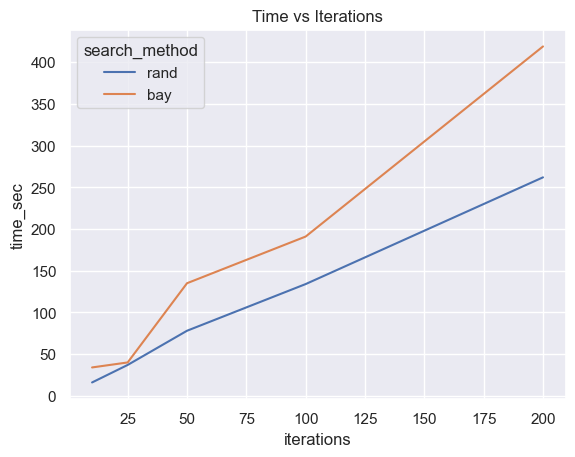

In [192]:
sns.lineplot(data=trial_results, y='time_sec', x='iterations', hue='search_method')
plt.title('Time vs Iterations')

Text(0.5, 1.0, 'RMSE vs Iterations')

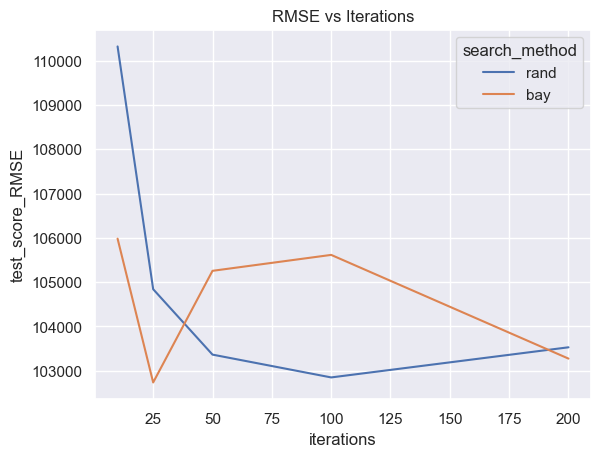

In [193]:
sns.lineplot(data=trial_results, y='test_score_RMSE', x='iterations', hue='search_method')
plt.title('RMSE vs Iterations')